# Music Auto-tagging Model
- In this assignment, you will train your auto-tagging model using PyTorch
- The dataset is from **MagnaTagATune**
  - Randomly selected 8000 mp3 files
  - 5000 files for training, 1000 for validation, 2000 for test  
    - **주의**: 메모리가 부족하거나 학습이 오래 걸릴 경우 dataset 함수 load 시 num_max_data를 줄여서 해결
 
- Problem 1: Complete Three Dataset Classes
- Problem 2: Practice with nn.Sequential()
- Problem 3: Make Your Own Conv Layers
- Probelm 4: Try Various Settings and Report
- Problem 5: Complete Binary Cross Entropy Function
- Problem 6: Complete Precision-Recall Area Under Curve Function
- Problem 7: Load audio and make prediction

In [ ]:
!add-apt-repository -y ppa:savoury1/ffmpeg4
!apt-get -qq install -y ffmpeg

In [ ]:
DEV = 'cuda' # select your device 'cpu' or 'cuda'

## 0. Import Library

In [ ]:
import torch
import torch.nn as nn
import torchaudio
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import IPython.display as ipd
from datetime import datetime

def save_fig_with_date(figname):
  plt.savefig(f"{figname}_{datetime.now().strftime('%m_%d_%H_%M_%S')}.png")

- Download dataset from Google Drive link and Unzip at `MTAT_SMALL/`

In [ ]:
%mkdir MTAT_SMALL
%cd MTAT_SMALL
%pwd

/content/MTAT_SMALL


'/content/MTAT_SMALL'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!7z x /content/drive/MyDrive/MTAT_SMALL.7z
# !unzip -q mtat_8000.zip
# !rm ./mtat_8000.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 912960560 bytes (871 MiB)

Extracting archive: /content/drive/MyDrive/MTAT_SMALL.7z
--
Path = /content/drive/MyDrive/MTAT_SMALL.7z
Type = 7z
Physical Size = 912960560
Headers Size = 126254
Method = LZMA2:24
Solid = +
Blocks = 2

  0%      0% - meta.csv                 0% 24 - 2/aba_structure-tektonik_illusion-06-euphorbia-407-436.mp3                                                                      1% 60 - d/ambient_teknology-the_all_s . -02-all_se

## Problem 1. Complete Dataset Class
- In this problem, you have to implement three ways to load the data
    - 1) Load audio file and resample every time the data is called **(OnTheFlyDataset)**
        - 매번 파일을 불러와서 전처리하는 방식
    - 2) Save pre-processed data in .pt file and load it every time the data is called **(PreProcessDataset)**
        - 전처리한 파일을 하드디스크에 저장 후 불러오는 방식
    - 3) Load every audio file on memory before the training starts **(OnMemoryDataset)**
        - 메모리(RAM)에 저장 후 불러오는 방식

In [ ]:
'''
You don't have to change this cell
'''
class MTATDataset:
  def __init__(self, dir_path, split='train', num_max_data=4000, sr=16000):
    self.dir = Path(dir_path)
    self.labels = pd.read_csv(self.dir / "meta.csv", index_col=[0])
    self.sr = sr

    if split=="train":
      sub_dir_ids = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c']
    elif split=='valid':
      sub_dir_ids = ['d']
    else: #test
      sub_dir_ids = ['e', 'f', 'g']

    is_in_set = [True if x[0] in sub_dir_ids else False for x in self.labels['mp3_path'].values.astype('str')]
    self.labels = self.labels.iloc[is_in_set]
    self.labels = self.labels[:num_max_data]
    self.vocab = self.labels.columns.values[1:-1]
    self.label_tensor = self.convert_label_to_tensor()
  
  def convert_label_to_tensor(self):
    return torch.LongTensor(self.labels.values[:, 1:-1].astype('bool'))

  def __len__(self):
    return len(self.labels)
  

MTAT_DIR = Path('/content/MTAT_SMALL')

In [ ]:
'''
Check how baseline dataset looks like
'''

base_set = MTATDataset(MTAT_DIR)

'''
metadata of dataset is stored in self.labels
'''
base_set.labels

clip_id  singer  harpsichord  sitar  heavy  foreign  no piano  \
20552    45147       0            0      0      0        0         0   
3899      8539       0            0      0      0        0         0   
8996     19647       0            0      0      0        0         0   
4055      8856       0            0      0      0        0         0   
6361     13834       0            0      0      0        0         0   
...        ...     ...          ...    ...    ...      ...       ...   
15397    33729       0            0      0      0        0         0   
19285    42374       0            0      0      0        0         0   
4099      8934       0            0      1      0        0         0   
18897    41453       0            0      0      0        0         0   
5813     12758       0            0      0      0        0         0   

       classical  female  jazz  ...  rock  dance  cello  techno  flute  beat  \
20552          0       1     0  ...     0      0      0       0      0     0   
3899           0       0     0  ...     0      0      0       0      0     0   
8996           0       0     0  ...     0      0      0       0      0     0   
4055           0       0     0  ...     0      0      0       0      0     0   
6361           1       0     0  ...     0      0      0       0      0     0   
...          ...     ...   ...  ...   ...    ...    ...     ...    ...   ...   
15397          0       0     0  ...     0      0      0       0      0     0   
19285          0       0     0  ...     0      0      0       0      0     0   
4099           0       0     0  ...     0      0      0       0      0     0   
18897          0       0     0  ...     0      0      0       0      1     0   
5813           1       0     0  ...     0      0      0       0      1     0   

       soft  choir  baroque                                           mp3_path  
20552     0      1        0  2/zephyrus-angelus-11-ave_maria__virgo_serena_...  
3899      0      0        0     a/tilopa-pictures_of_silence-02-ni-175-204.mp3  
8996      0      0        0  5/arthur_yoria-of_the_lovely-04-several_mistak...  
4055      0      0        0  8/stargarden-music_for_modern_listening-02-per...  
6361      0      0        0  a/dac_crowell-the_mechanism_of_starlight-03-me...  
...     ...    ...      ...                                                ...  
15397     0      0        0  4/jami_sieber-second_sight-07-the_goats_earth-...  
19285     0      0        0  9/self_delusion-happiness_hurts_me-10-dead_sta...  
4099      0      0        0  c/jamie_janover-now_center_of_time-02-playa-20...  
18897     0      0        0       2/jesse_manno-sea_spirits-09-tidur-59-88.mp3  
5813      0      0        1  6/philharmonia_baroque-rameau_and_leclair-03-e...  

[4000 rows x 52 columns]

In [ ]:
'''
You can use labels['mp3_path'].iloc
'''
target_idx = 0 

path_to_target_idx = base_set.labels['mp3_path'].iloc[target_idx]
print(path_to_target_idx)

2/zephyrus-angelus-11-ave_maria__virgo_serena_josquin_des_prez-0-29.mp3


In [ ]:
'''
label of each tensor is also stored in self.label_tensor
'''
base_set.label_tensor

tensor([[0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1]])

In [ ]:
class OnTheFlyDataset(MTATDataset):
  def __init__(self, dir_path, split='train', num_max_data=4000, sr=16000):
    super().__init__(dir_path, split, num_max_data, sr)
    
  def __getitem__(self, idx):
    '''
    __getitem__ returns a corresponding idx-th data sample among the dataset.
    In music-tag dataset, it has to return (audio_sample, label) of idx-th data.
    
    OnTheFlyDataset loads the audio file whenever this __getitem__ function is called.
    In this function, you have to implement these things
    
    1) Get the file path of idx-th data sample (use self.labels['mp3_path'])
    2) Load the audio of that file path 
    3) Resample the audio sample into frequency of self.sr (You can use torchaudio.functional.resample)
    4) Return resampled audio sample and the label (tag data) of the data sample
    
    Output
      audio_sample (torch.FloatTensor):  
      label (torch.FloatTensor): A tensor with shape of 50 dimension. Each dimension has value either 0 or 1
                                 If n-th dimension's value is 1, it means n-th tag is True for this data sample
    
    TODO: Complete this function
    '''
    path_to_idx = self.labels['mp3_path'].iloc[idx]
    waveform, sample_rate = torchaudio.load(path_to_idx)

    audio_sample = torchaudio.functional.resample(waveform, sample_rate, self.sr, lowpass_filter_width=6).mean(dim=0)
    #Using a larger lowpass_filter_width provides a sharper, more precise filter, but is more computationally expensive.
    label = self.label_tensor[idx]
    return audio_sample, label

dummy_set = OnTheFlyDataset(MTAT_DIR, split='train', num_max_data=100)
audio, label = dummy_set[1]
assert audio.ndim == 1, "Number of dimensions of audio tensor has to be 1. Use audio[0] or audio.mean(dim=0) to reduce it"
ipd.display(ipd.Audio(audio, rate=dummy_set.sr))
print(dummy_set.vocab[torch.where(label)])

ambient


In [ ]:
class PreProcessDataset(MTATDataset):
  def __init__(self, dir_path, split='train', num_max_data=8000, sr=16000):
    super().__init__(dir_path, split, num_max_data, sr)
    
    self.pre_process_and_save_data()
    
  def pre_process_and_save_data(self):
    '''
    self.pre_process_and_save_data loads every audio sample in the dataset, resample it, and save it into pt file.
    In this function, you have to implement these things
    
    1) For every data sample in the dataset, check whether pre-processed data already exists
      - You can get data sample path by self.labels['mp3_path'].values()
      - path of pre-processed data can be in the same directory, but with different suffix.
      - You can make it with Path(mp3_path).with_suffix('.pt')
    2) If it doesn't exist, do follow things
      a) Load audio file 
      b) Resample the audio file with samplerate of self.sr
      c) Get label of this audio file
      d) Save {'audio': audio_tensor, 'label':label_tensor} with torch.save

    Output
      None
    
    TODO: Complete this function
    '''
    for i in range(len(self.labels['mp3_path'])):
      path = self.labels['mp3_path'].values[i]
      resampled_path = Path(path).with_suffix('.pt')
      if not resampled_path.exists():
        waveform, sample_rate = torchaudio.load(path)
        audio_sample = torchaudio.functional.resample(waveform, sample_rate, self.sr, lowpass_filter_width=6).mean(dim=0)
        label = self.label_tensor[i]
        torch.save({'audio':audio_sample, 'label':label}, resampled_path)

    
  def __getitem__(self, idx):
    '''
    __getitem__ returns a corresponding idx-th data sample among the dataset.
    In music-tag dataset, it has to return (audio_sample, label) of idx-th data.
    
    PreProcessDataset loads the pre-processed pt file whenever this __getitem__ function is called.
    In this function, you have to implement these things
    
    1) Get the pt file path of idx-th data sample (use self.labels)
    2) Load the pre-procssed data of that file path (use torch.load)
    3) Return the audio sample and the label (tag data) of the data sample

    TODO: Complete this function
    '''

    path = Path(self.labels['mp3_path'].values[idx]).with_suffix('.pt')
    return torch.load(path)['audio'], torch.load(path)['label']
  
dummy_set = PreProcessDataset(MTAT_DIR, split='train', num_max_data=100)
audio, label = dummy_set[15]
assert audio.ndim == 1, "Number of dimensions of audio tensor has to be 1. Use audio[0] or audio.mean(dim=0) to reduce it"
ipd.display(ipd.Audio(audio, rate=dummy_set.sr))
print(dummy_set.vocab[torch.where(label)])

['guitar' 'male']


In [ ]:
class OnMemoryDataset(MTATDataset):
  def __init__(self, dir_path, split='train', num_max_data=4000, sr=16000):
    super().__init__(dir_path, split, num_max_data, sr)
    
    self.loaded_audios = self.load_audio()
    
  def load_audio(self):
    '''
    In this function, you have to load all the audio file in the dataset, and resample them, 
    and store the data on the memory as a python variable
    
    For each data in the dataset,
      a) Load Audio
      b) Resample it to self.sr
      c) Append it to total_audio_datas
    
    Output:
      total_audio_datas (list): A list of torch.FloatTensor. i-th item of the list corresponds to the audio sample of i-th data
                                Each item is an audio sample in torch.FloatTensor with sampling rate of self.sr 
    '''
    total_audio_datas = []
    for path in self.labels['mp3_path']:
      waveform, sample_rate = torchaudio.load(path)
      audio_sample = torchaudio.functional.resample(waveform, sample_rate, self.sr, lowpass_filter_width=6).mean(dim=0)
      total_audio_datas.append(audio_sample)
    
    ### Write your code from here
    return total_audio_datas

  def __getitem__(self, idx):
    '''
    __getitem__ returns a corresponding idx-th data sample among the dataset.
    In music-tag dataset, it has to return (audio_sample, label) of idx-th data.
    
    OnMemoryDataset returns the pre-loaded audio data that is aved on self.loaded_audios whenever this __getitem__ function is called.
    In this function, you have to implement these things
    
    1) Load the pre-procssed audio data from self.loaded_audios
    2) Return the audio sample and the label (tag data) of the data sample

    TODO: Complete this function
    '''
    
    return self.loaded_audios[idx], self.label_tensor[idx]
  
dummy_set = OnMemoryDataset(MTAT_DIR, split='train', num_max_data=50)
audio, label = dummy_set[10]
assert audio.ndim == 1, "Number of dimensions of audio tensor has to be 1. Use audio[0] or audio.mean(dim=0) to reduce it"
ipd.display(ipd.Audio(audio, rate=dummy_set.sr))
print(dummy_set.vocab[torch.where(label)])

['classical' 'quiet' 'ambient' 'string' 'harp' 'slow']


#### Define Dataset
- You can select one of your implementations

In [ ]:
your_dataset_class = PreProcessDataset # One of OnTheFlyDataset, PreProcessDataset, or OnMemoryDataset
# your_dataset_class = OnMemoryDataset
'''
Based on your memory size or storage size, you can change the num_max_data
코드 동작만 테스트하거나 컴퓨터 사양이 낮으면 num_max_data 줄여서 시도
'''
trainset = your_dataset_class(MTAT_DIR, split='train', num_max_data=2500)
validset = your_dataset_class(MTAT_DIR, split='valid', num_max_data=500)
testset = your_dataset_class(MTAT_DIR, split='test', num_max_data=1000)

#### DataLoader
- Define `DataLoader` using the dataset

In [ ]:
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0) # you can speed up with num_workers=4 if you have multiple cpu core
valid_loader = DataLoader(validset, batch_size=128, shuffle=False, num_workers=0)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

batch = next(iter(train_loader))

## Preparation: Define Neural Network
- Define the neural network

In [ ]:
class SpecModel(nn.Module):
  def __init__(self, sr, n_fft, hop_length, n_mels):
    super().__init__()
    self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    self.db_converter = torchaudio.transforms.AmplitudeToDB()
  
  def forward(self, x):
    mel_spec = self.mel_converter(x)
    return self.db_converter(mel_spec)

class AudioModel(nn.Module):
  def __init__(self, sr, n_fft, hop_length, n_mels, hidden_size, num_output):
    super().__init__()
    self.sr = sr
    self.spec_converter = SpecModel(sr, n_fft, hop_length, n_mels)
    self.conv_layer = nn.Sequential(
      nn.Conv1d(n_mels, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),     
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.MaxPool1d(3),
      nn.ReLU(),
    )
    self.final_layer = nn.Linear(hidden_size, num_output)

  def get_spec(self, x):
    '''
    Get result of self.spec_converter
    x (torch.Tensor): audio samples (num_batch_size X num_audio_samples)
    '''
    return self.spec_converter(x)
  
  def forward(self, x):
    spec = self.get_spec(x) # num_batch X num_mel_bins X num_time_bins
    out = self.conv_layer(spec)
    out = torch.max(out, dim=-1)[0] # select [0] because torch.max outputs tuple of (value, index)
    out = self.final_layer(out)
    out = torch.sigmoid(out)
    return out

## 3. Train the Network
- First, just run the cells below so that you can obtain the first result
- Plot the training loss and validation accuracy


In [ ]:
def get_tpr_fpr(pred, target, threshold=0.5):
  thresh_pred = pred> threshold
  p = torch.sum(target == 1)
  tp = torch.sum((thresh_pred==1) * (target==1))
  n = torch.sum(target == 0)
  fp = torch.sum((thresh_pred==1) * (target==0))
  return tp/p, fp/n

def get_roc_auc(pred, label, num_grid=500):
  auc = 0
  prev_fpr = 0
  for thresh in reversed(torch.linspace(0,1,num_grid)):
    tpr, fpr = get_tpr_fpr(pred, label, threshold=thresh)
    auc += tpr * (fpr-prev_fpr)
    prev_fpr = fpr
  return auc

def train_model(model, train_loader, valid_loader, optimizer, num_epochs, loss_func, device='cuda'):
  loss_records =[] 
  valid_acc_records = []
  model.vocab = train_loader.dataset.vocab
  model.train() # Set model to train mode
  for epoch in tqdm(range(num_epochs)):
    for batch in train_loader:
      optimizer.zero_grad() # Rest gradient of every parameters in optimizer (every parameters in the model)
      audio, label = batch
      audio = audio.to(device)
      label = label.to(device)
      pred = model(audio)
      loss = loss_func(pred, label.float())
      loss.backward() # Run backpropagation
      optimizer.step() # Update parameters
      loss_records.append(loss.item())
    valid_acc = validate_model(model, valid_loader, device)
    valid_acc_records.append(valid_acc.item())
  return {"loss": loss_records, "valid_acc": valid_acc_records}

def validate_model(model, valid_loader, device, acc_func=get_roc_auc):
  valid_acc = 0
  model.eval()
  model.to(device)
  with torch.no_grad():
    for batch in valid_loader:
      audio, label = batch
      pred = model(audio.to(device))
      auc = acc_func(pred, label.to(device))
      valid_acc += auc * len(label)
  model.train()
  return valid_acc / len(valid_loader.dataset)

In [ ]:
'''
Train the default model
'''

model = AudioModel(sr=16000, n_fft=1024, hop_length=512, n_mels=48, num_output=50, hidden_size=32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model = model.to(DEV)
loss_func = torch.nn.BCELoss()
train_record = train_model(model, train_loader, valid_loader, optimizer, num_epochs=30, loss_func=loss_func, device=DEV)


100%|██████████| 30/30 [17:16<00:00, 34.55s/it]


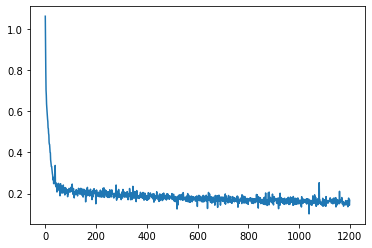

In [ ]:
plt.plot(train_record['loss'])
save_fig_with_date('default_train_loss')

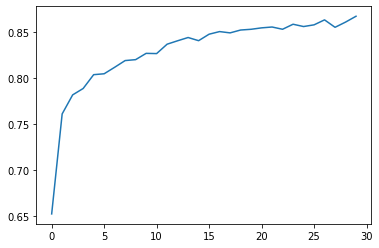

In [ ]:
plt.plot(train_record['valid_acc'])
save_fig_with_date('default_train_valid_acc')

### Problem 2. Practice with nn.Sequential()
- `nn.Sequential` automatically stacks the `nn.Module`
    - If `x = nn.Sequential( nn.Conv1d(48, 12) , nn.ReLU() )`,
        - `out = x(input)`
        - `x1 = nn.Conv1d(48,12)`, `x2=nn.ReLU()`, `out = x2(x1(input))`
        
        위의 두 줄이 같은 동작


In [ ]:
class StackManualLayer(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Conv1d(16, 4, kernel_size=2)
    self.activation = nn.Sigmoid()
    self.layer2 = nn.Conv1d(4, 4, kernel_size=2)
    self.layer3 = nn.Conv1d(4, 1, kernel_size=2)
    
  def forward(self, x):
    out = self.layer1(x)
    out = self.activation(out)
    out = self.layer2(out)
    out = self.activation(out)
    out = self.layer3(out)
    return out

class SequentialLayer(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv1d(16, 4, kernel_size=2),
        nn.Sigmoid(),
        nn.Conv1d(4, 4, kernel_size=2),
        nn.Sigmoid(),
        nn.Conv1d(4, 1, kernel_size=2)
    )
  def forward(self, x):
    out = self.layers(x)
    return out
  
# Do not change the code below
torch.manual_seed(0)
manual_layer = StackManualLayer()
torch.manual_seed(0)
sequential_layer = SequentialLayer()

'''
The printed result has to be same
'''

test_dummy = torch.arange(128).view(1,16,8).float()
manual_out = manual_layer(test_dummy)
print(f"Output with Manual Stack Layer: {manual_out}")
sequential_out = sequential_layer(test_dummy)
print(f"Output with Sequential Layer: {sequential_out}")




Output with Manual Stack Layer: tensor([[[0.0241, 0.0263, 0.0280, 0.0291, 0.0300]]],
       grad_fn=<ConvolutionBackward0>)
Output with Sequential Layer: tensor([[[0.0241, 0.0263, 0.0280, 0.0291, 0.0300]]],
       grad_fn=<ConvolutionBackward0>)


### Problem 3. Make Your Own Conv Layers
- Complete the `self.conv_layer` of `YourModel`
- Train the model and compare the result
- In your report, explain your conv_layer and the training result
    - How did you change the structure of CNN?
    - What is the difference?

In [ ]:
class YourModel(AudioModel):
  def __init__(self, sr, n_fft, hop_length, n_mels, hidden_size, num_output):
    super().__init__(sr, n_fft, hop_length, n_mels, hidden_size, num_output)
    '''
      TODO: Complete your new conv layer =
      Example:
      self.conv_layer = nn.Sequential(
        nn.Conv1d(n_mels, out_channels=hidden_size, kernel_size=3),
        nn.MaxPool1d(3),
        nn.ReLU(),
        nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
        nn.MaxPool1d(3),
        nn.ReLU()
    )
      '''
    self.conv_layer = nn.Sequential(
        nn.Conv1d(n_mels, out_channels=hidden_size, kernel_size=4),
        nn.BatchNorm1d(hidden_size),
        nn.MaxPool1d(4),
        nn.ReLU(),
        nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=4),
        nn.BatchNorm1d(hidden_size),
        nn.MaxPool1d(4),
        nn.ReLU()
    )
    self.final_layer = nn.Linear(hidden_size, num_output)


class YourModel2(AudioModel):
  def __init__(self, sr, n_fft, hop_length, n_mels, hidden_size, num_output):
    super().__init__(sr, n_fft, hop_length, n_mels, hidden_size, num_output)
    '''
      TODO: Complete your new conv layer =
      Example:
      self.conv_layer = nn.Sequential(
        nn.Conv1d(n_mels, out_channels=hidden_size, kernel_size=3),
        nn.MaxPool1d(3),
        nn.ReLU(),
        nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
        nn.MaxPool1d(3),
        nn.ReLU()
    )
      '''
    self.conv_layer = nn.Sequential(
        nn.Conv1d(n_mels, out_channels=hidden_size, kernel_size=3),
        nn.BatchNorm1d(hidden_size),
        nn.MaxPool1d(3),
        nn.ReLU(),
        nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
        nn.BatchNorm1d(hidden_size),
        nn.MaxPool1d(3),
        nn.ReLU()
    )
    self.final_layer = nn.Linear(hidden_size, num_output)

In [ ]:
your_model = YourModel(sr=16000, n_fft=1024, hop_length=512, n_mels=48, num_output=50, hidden_size=32)
optimizer = torch.optim.Adam(your_model.parameters(), lr=1e-3)
your_model = your_model.to(DEV)
your_train_record = train_model(your_model, train_loader, valid_loader, optimizer, num_epochs=30, loss_func=loss_func, device=DEV)

100%|██████████| 30/30 [18:47<00:00, 37.57s/it]


In [ ]:
your_model2 = YourModel2(sr=16000, n_fft=1024, hop_length=512, n_mels=48, num_output=50, hidden_size=32)
optimizer = torch.optim.Adam(your_model2.parameters(), lr=1e-3)
your_model2 = your_model2.to(DEV)
your_train_record2 = train_model(your_model2, train_loader, valid_loader, optimizer, num_epochs=30, loss_func=loss_func, device=DEV)

100%|██████████| 30/30 [20:09<00:00, 40.31s/it]


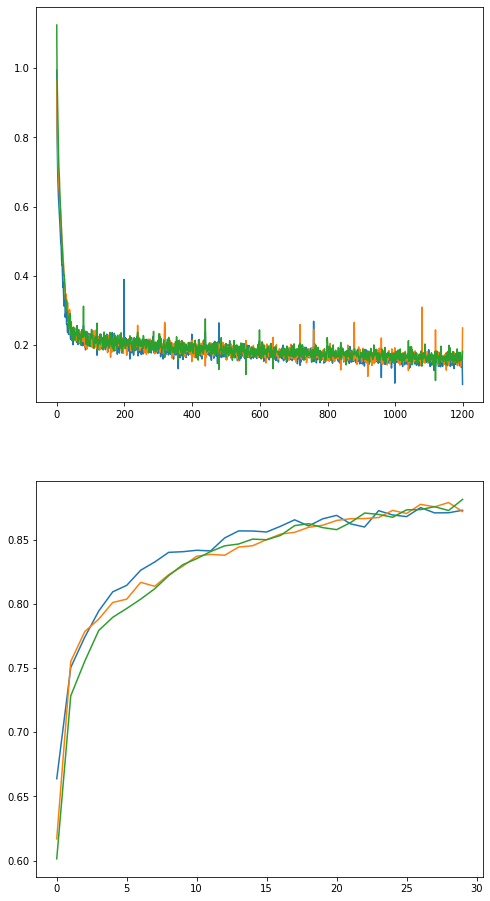

In [ ]:
## Save the figure with comparison of default setting
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)
plt.plot(train_record['loss'])
plt.plot(your_train_record['loss'])
plt.plot(your_train_record2['loss'])
plt.subplot(2,1,2)
plt.plot(train_record['valid_acc'])
plt.plot(your_train_record['valid_acc'])
plt.plot(your_train_record2['valid_acc'])
save_fig_with_date('your_conv_layer_comparison_with_default')

Batch Normalization을 실시하고 kernel_size를 변경하여 보았지만 accuracy에서 큰 변화가 없었다.

### Probelm 4. Try Various Settings and Report
- You can try different `n_fft`, `n_mels`, or `hidden_size`, or different `conv_layer` in your model
- Describe the result and your analysis in your report
    - Why you tried those changes
    - What you have expected from the result with those changes
    - What you got from the changes

100%|██████████| 30/30 [17:53<00:00, 35.80s/it]


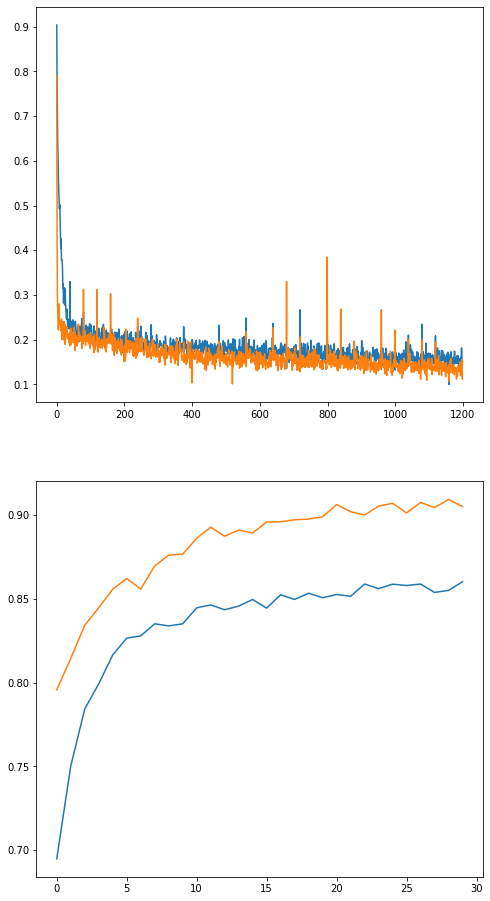

In [ ]:
your_model = YourModel(sr=16000, n_fft=1024, hop_length=512, n_mels=48, num_output=50, hidden_size=64)
# n_fft: 연속적인 주파수를 이산적으로 나누는 것
# n_mels: 적용할 mel filter의 개수
optimizer = torch.optim.Adam(your_model.parameters(), lr=1e-2)
your_model = your_model.to(DEV)
your_train_record = train_model(your_model, train_loader, valid_loader, optimizer, num_epochs=30, loss_func=loss_func, device=DEV)

## Save the figure with comparison of default setting
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)
plt.plot(train_record['loss'])
plt.plot(your_train_record['loss'])
plt.subplot(2,1,2)
plt.plot(train_record['valid_acc'])
plt.plot(your_train_record['valid_acc'])
save_fig_with_date('comparison_with_default')

hidden_size: feature dimension의 개수를 늘려 모델이 더 세밀하게 feature를 뽑아낼 수 있을 것이라 생각했다.  
lr: 컴퓨터 성능의 문제로 데이터셋을 줄인 대신, learning rate를 대폭 늘림으로써 학습 성능이 향상되리라 기대했다.  
실제로 원래의 모델보다 하이퍼 파라미터 튜닝을 통해 accuracy가 향상된 것을 확인할 수 있다.

In [ ]:
'''
Get the test result
'''
test_acc = validate_model(your_model, test_loader, DEV)
print(f"Calculated ROC_AUC value for Test Set is : {test_acc:.4f}")

Calculated ROC_AUC value for Test Set is : 0.9007


### Problem 5 Complete Binary Cross Entropy Function
- Complete the function that can calculate the Binary Cross Entropy for given prediction and target label without using `torch.BCELoss`
- yi, yi_hat 순서 조심
- ![bce](https://androidkt.com/wp-content/uploads/2021/05/Selection_099.png)

100%|██████████| 5/5 [02:56<00:00, 35.24s/it]


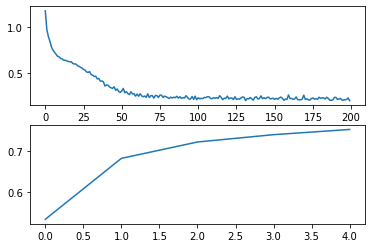

In [ ]:
def get_binary_cross_entropy(pred:torch.Tensor, target:torch.Tensor):
  '''
  pred (torch.Tensor): predicted value of a neural network model for a given input (assume that the value is output of sigmoid function)
  target (torch.Tensor): ground-truth label for a given input, given in multi-hot encoding

  output (torch.Tensor): Mean Binary Cross Entropy Loss value of every sample
  '''
  # TODO: Complete this function
  # print(pred)
  # print(target)
  return -(target*torch.log(pred) + (1-target)*torch.log(1-pred)).mean()

test_model = AudioModel(sr=16000, n_fft=1024, hop_length=512, n_mels=48, num_output=50, hidden_size=16)
test_model = test_model.to(DEV)
test_optimizer = torch.optim.Adam(test_model.parameters(), lr=1e-3)
train_record = train_model(test_model, train_loader, valid_loader, test_optimizer, num_epochs=5, loss_func=get_binary_cross_entropy, device=DEV)
plt.subplot(2,1,1)
plt.plot(train_record['loss'])
plt.subplot(2,1,2)
plt.plot(train_record['valid_acc'])
save_fig_with_date('handmade_bce_result')

### Problem 6. Complete Precision-Recall Area Under Curve Function
- One of the frequently used metric is Precision-Recall Area Under Curve (PR-AUC)
- Precision is (Number of true positive)/(Number of total positive predictions)
- Recall is (Number of true positive)/(Number of total positive ground-truth)
- Precision and recall values depend on threshold
- PR-AUC is the area under precision-recall curve of varying trheshold
- You can refer the pre-defined `get_roc_auc` function

In [ ]:
def get_precision_and_recall(pred:torch.Tensor, target:torch.Tensor, threshold:float):
  '''
  This function calculates precision and recall of given (prediction, target, threshold)
  
  pred (torch.Tensor): predicted value of a neural network model for a given input 
  target (torch.Tensor): ground-truth label for a given input, given in multi-hot encoding

  output
    precision (torch.Tensor): (Number of true positive)/(Number of total positive predictions)
    recall (torch.Tensor): (Number of true positive)/(Number of total positive ground-truth)
    
  IMPORTANT:
    To prevent division by zero, make the denominator greater than zero.
  
  TODO: Complete this function
  '''
  # print((pred > threshold) * target) 

  # Write your code here
  precision = torch.sum((pred > threshold) * target) / torch.sum(pred > threshold) # TP / TP+FP
  recall = torch.sum((pred > threshold) * target) / torch.sum(target) # TP / TP+FN
  if torch.isnan(precision):
    precision = torch.tensor(0)
  elif torch.isnan(recall):
    recall = torch.tensor(0)
  # print(precision)
  # print(recall)
  '''
  Be careful for not returning nan because of division by zero
  '''
  assert not (torch.isnan(precision) or torch.isnan(recall))
  return precision, recall

def get_precision_recall_auc(pred:torch.Tensor, target:torch.Tensor, num_grid=500):
  '''
  This function returns PR_AUC value for a given prediction and target.
  Assume pred.shape == target.shape
  
  pred (torch.Tensor): predicted value of a neural network model for a given input 
  target (torch.Tensor): ground-truth label for a given input, given in multi-hot encoding

  output (torch.Tensor): Area Under Curve value for Precision-Recall Curve
  
  TODO: Complete this function using get_precision_and_recall
  '''
  auc = 0
  pre = 0

  for thres in reversed(torch.linspace(0, 1, num_grid)):
    precision, recall = get_precision_and_recall(pred, target, threshold=thres)
    auc += precision * (recall - pre)
    pre = recall

  return auc


In [ ]:
'''
Test the get_precision_recall_auc
dummy 변수를 이용한 테스트
'''

dummy_pred = torch.Tensor([0.0285,     0.0004,     0.0483,     0.0003,     0.0074,     0.0141,
            0.0007,     0.0735,     0.0534,     0.0153,     0.0024,     0.0053,
            0.0004,     0.1033,     0.1007,     0.4314,     0.1744,     0.0119,
            0.0189,     0.0075,     0.0001,     0.1354,     0.0014,     0.0004,
            0.4431,     0.0236,     0.0005,     0.1276,     0.0173,     0.0000,
            0.0010,     0.1237,     0.0616,     0.1674,     0.0000,     0.0053,
            0.0984,     0.0608,     0.1783,     0.0689,     0.0509,     0.0011,
            0.0749,     0.0001,     0.6105,     0.0136,     0.2644,     0.0204,
            0.0005,     0.0001])
dummy_target = torch.Tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0])

'''
Printed result of code below has to be tensor(0.1753)
'''
get_precision_recall_auc(dummy_pred, dummy_target) 

tensor(0.1753)

In [ ]:
selected_model = model
pr_auc_value_valid = validate_model(selected_model, valid_loader, DEV, acc_func=get_precision_recall_auc)
pr_auc_value_test = validate_model(selected_model, test_loader, DEV, acc_func=get_precision_recall_auc)
print(f"Calculated PR_AUC value for Validation Set is : {pr_auc_value_valid.item():.4f}")
print(f"Calculated PR_AUC value for Test Set is : {pr_auc_value_test.item():.4f}")

Calculated PR_AUC value for Validation Set is : 0.3404
Calculated PR_AUC value for Test Set is : 0.3851


### Problem 7: Load audio and make prediction
- Upload mp3 file of your choice
    - If you are using Colab, you can upload file by opening File Browser at the sidebar
- Try several audio files and report the result by comparing your expectation and model's output
- You can get different result by modifying `THRESHOLD`
    - `THRESHOLD` has to be a value between 0 and 1
    - If you lower the `THRESHOLD`, more tags will be printed out
- Complete `slice_audio` function

In [ ]:
your_audio_path = '/content/Alone_-_Color_Out.mp3' #TODO
selected_model = your_model # Change it if you want to select model with different name

In [ ]:
def get_resampled_mono_audio_from_file(audio_file_path, target_sr):
  y, sr = torchaudio.load(audio_file_path)
  if sr!= selected_model.sr:
    y = torchaudio.functional.resample(y, orig_freq=sr, new_freq=selected_model.sr)
  if y.shape[0] > 1:
    y = torch.sum(y, dim=0) / y.shape[0]
  
  return y

def slice_audio(audio_sample, sr, start_sec, end_sec):
  '''
  This function takes an audio sample, sampling rate, and start/end position of slice
  and returns the sliced audio sample.
  
  audio_sample (torch.Tensor): A sequence of audio samples in shape of (N,), where N is number of audio samples
  sr (int): Sampling rate of audio_sample
  start_sec (float): desired slice start position in seconds
  end_sec (float): desired slice end position in seconds
  
  output (torch.Tensor): A sequence of audio samples in shape of (int(sr*(end_sec-start_sec)), ) 
  
  
  TODO: Complete this function
  '''

  slice = audio_sample[sr*start_sec:sr*end_sec]
  # ipd.display(ipd.Audio(slice, rate=sr))
  return slice

In [ ]:
'''
Run Model
'''


THRESHOLD = 0.2
y = get_resampled_mono_audio_from_file(your_audio_path, selected_model.sr)

'''
You can slice your desired position
'''
sliced_y = slice_audio(y, selected_model.sr, 0, 30) 


with torch.no_grad():
  pred = selected_model(sliced_y.unsqueeze(0).to(DEV)).to('cpu')
pred = pred[0]
ipd.display(ipd.Audio(sliced_y, rate=selected_model.sr))
print(f"Predicted tags are: {model.vocab[torch.where(pred>THRESHOLD)]}")

Predicted tags are: []


In [ ]:
'''
Run Model
'''


THRESHOLD = 0.1
y = get_resampled_mono_audio_from_file(your_audio_path, selected_model.sr)

'''
You can slice your desired position
'''
sliced_y = slice_audio(y, selected_model.sr, 0, 30) 


with torch.no_grad():
  pred = selected_model(sliced_y.unsqueeze(0).to(DEV)).to('cpu')
pred = pred[0]
ipd.display(ipd.Audio(sliced_y, rate=selected_model.sr))
print(f"Predicted tags are: {model.vocab[torch.where(pred>THRESHOLD)]}")

Predicted tags are: ['guitar' 'slow' 'no singer']


threshold를 기본값으로 설정했더니 아무런 라벨도 출력되지 않았다. 따라서 threshold를 0.1로 낮추자 guitar, slow, no singer라는 태그가 출력됐다.